<a href="https://colab.research.google.com/github/The1AndOnlyAlex/PyTorch-MNIST/blob/main/COCO2017.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import torch
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import os
import torchvision.transforms as transforms
import json

!pip install kagglehub
import kagglehub

In [9]:
from google.colab import files
files.upload() # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alexanderduan","key":"10010e5ff0b830bf6415694194f7872e"}'}

In [10]:
# !pip install kaggle
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# Download latest version
path = kagglehub.dataset_download("awsaf49/coco-2017-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'coco-2017-dataset' dataset.
Path to dataset files: /kaggle/input/coco-2017-dataset


In [11]:
class COCOObjectDetectionDataset(Dataset):
    def __init__(self, image_dir, annotation_file, transform=None):
        # List image files
        self.image_dir = image_dir
        self.transform = transform or transforms.ToTensor()

        # Load annotations
        with open(annotation_file, 'r') as f:
            data = json.load(f)

        # Map image_id -> file_name
        self.imgs = {img['id']: img['file_name'] for img in data['images']}
        # Map image_id -> all bounding boxes and labels
        self.image_instances = {}
        for ann in data['annotations']:
            img_id = ann['image_id']
            bbox = ann['bbox']
            label = ann['category_id']
            if img_id not in self.image_instances:
                self.image_instances[img_id] = []
            self.image_instances[img_id].append((bbox, label))
        # List of image IDs with labels
        self.image_ids = list(self.image_instances.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, self.imgs[img_id])
        image = Image.open(img_path).convert('RGB')
        target = self.image_instances[img_id]  # list of (bbox, label)

        boxes = [x[0] for x in target]
        labels = [x[1] for x in target]

        if self.transform:
            image = self.transform(image)
        return image, boxes, labels

# Usage:
train_images_dir = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
train_annotation_file = '/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_train2017.json'


In [12]:
train_ds = COCOObjectDetectionDataset(train_images_dir, train_annotation_file)

In [13]:
img, boxes, labels = train_ds[0]

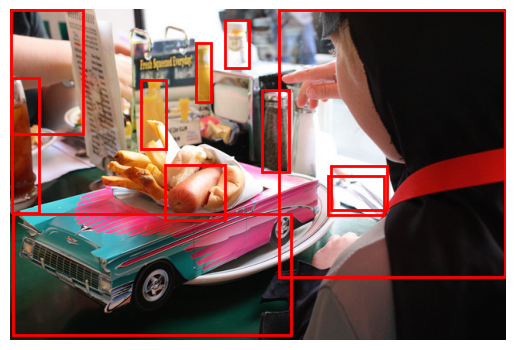

In [14]:
# Displaying the image and label of index 0 graphically

# Convert tensor to numpy (if needed) for plotting
img_np = img.permute(1, 2, 0).cpu().numpy()

fig, ax = plt.subplots(1)
ax.imshow(img_np)

for box in boxes:
    x, y, w, h = box
    rect = plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2)
    ax.add_patch(rect)

plt.axis('off')
plt.show()

In [15]:
def get_category_names(annotation_file):
    with open(annotation_file, 'r') as f:
        data = json.load(f)
    return {cat['id']: cat['name'] for cat in data['categories']}

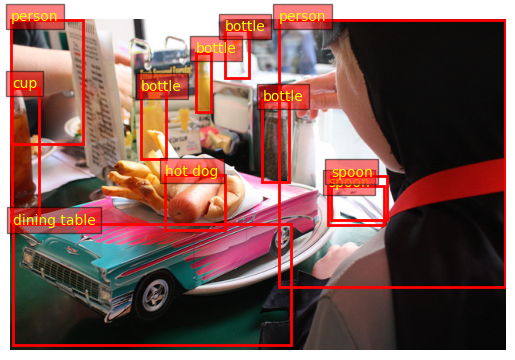

In [16]:
category_names = get_category_names(train_annotation_file)

fig, ax = plt.subplots(1)
ax.imshow(img_np)

for box, label_id in zip(boxes, labels):
    x, y, w, h = box
    rect = plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2)
    ax.add_patch(rect)
    # Draw category name on the box
    label_name = category_names[label_id]
    ax.text(x, y, label_name, fontsize=10, color='yellow',
            bbox=dict(facecolor='red', alpha=0.5))

plt.axis('off')
plt.show()

In [17]:
len(train_ds)

117266

In [18]:
train_ds[0]

(tensor([[[0.0902, 0.0824, 0.0824,  ..., 0.0392, 0.0353, 0.0510],
          [0.0863, 0.0824, 0.0824,  ..., 0.0471, 0.0431, 0.0471],
          [0.0667, 0.0667, 0.0745,  ..., 0.0431, 0.0431, 0.0392],
          ...,
          [0.1059, 0.1137, 0.0980,  ..., 0.0275, 0.0235, 0.0196],
          [0.1020, 0.1137, 0.1020,  ..., 0.0275, 0.0235, 0.0196],
          [0.0941, 0.1098, 0.1059,  ..., 0.0275, 0.0275, 0.0196]],
 
         [[0.0902, 0.0824, 0.0745,  ..., 0.0353, 0.0314, 0.0471],
          [0.0902, 0.0863, 0.0784,  ..., 0.0392, 0.0392, 0.0431],
          [0.0824, 0.0824, 0.0784,  ..., 0.0353, 0.0431, 0.0392],
          ...,
          [0.1098, 0.1020, 0.1059,  ..., 0.0275, 0.0235, 0.0196],
          [0.1059, 0.1020, 0.1098,  ..., 0.0275, 0.0235, 0.0196],
          [0.0980, 0.0980, 0.1137,  ..., 0.0275, 0.0275, 0.0196]],
 
         [[0.0980, 0.0902, 0.0941,  ..., 0.0275, 0.0235, 0.0392],
          [0.1059, 0.1020, 0.0980,  ..., 0.0431, 0.0314, 0.0353],
          [0.0941, 0.0941, 0.0941,  ...,

In [19]:
image, boxes, labels = train_ds[0]
labelsTensor = torch.tensor(labels)
labelsTensor

tensor([58, 44, 44, 47,  1, 44, 50,  1, 44, 67, 50])

In [20]:
boxesTensor = torch.tensor(boxes)
boxesTensor.shape

torch.Size([11, 4])

In [21]:
imageTensor = torch.tensor(image)
imageTensor.shape

/tmp/ipython-input-1800765975.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imageTensor = torch.tensor(image)


torch.Size([3, 427, 640])

In [22]:
!pip install ultralytics

from ultralytics import YOLO

In [ ]:
# Load pretrained YOLOv8 nano model to fine-tune (small, fast)
model = YOLO("yolov8n.pt")

# Start training on your dataset.yaml config for e.g. 10 epochs *reduced to 5
# Adjust imgsz, batch, epochs as needed
model.train(data="dataset.yaml", epochs=5, imgsz=640, batch=16)

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained

In [ ]:
# Convert your image tensor (C,H,W) with values [0..1] to uint8 np array (H,W,C)
img_np = (image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

# Run prediction
results = model.predict(img_np)

In [ ]:
# The results object contains list of detected boxes, class ids, and confidence scores
for r in results:
    boxes = r.boxes.xyxy.cpu().numpy()   # Bounding boxes: Nx4 array [x_min, y_min, x_max, y_max]
    scores = r.boxes.conf.cpu().numpy()  # Confidence scores
    class_ids = r.boxes.cls.cpu().numpy() # Class ids indexes

    print("Boxes:", boxes)
    print("Scores:", scores)
    print("Class IDs:", class_ids)

    # You can map class_ids to class names using model.names dictionary
    class_names = [model.names[int(c)] for c in class_ids]
    print("Detected classes:", class_names)

# **Plot Predicted Boxes on your Image**

In [ ]:
fig, ax = plt.subplots(1)
ax.imshow(img_np)

for box, score, class_id in zip(boxes, scores, class_ids):
    x1, y1, x2, y2 = box
    # Draw rectangle: (x_min, y_min), width, height
    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='red', linewidth=2)
    ax.add_patch(rect)
    label = f"{model.names[int(class_id)]}: {score:.2f}"
    ax.text(x1, y1, label, fontsize=8, color='yellow', bbox=dict(facecolor='red', alpha=0.5))

plt.axis('off')
plt.show()